In [1]:
# 因子一：alpha08/alpha101

import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, alpha, chart_name='dv_alpha08_ma', ShortPeriod=20, LongPeriod=55, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(alpha.iloc[n:], alpha=0.2)
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
#     plt.savefig(chart_name)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('alpha08_C',"-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))",add_data=True).tail(10)

Initialize dataview success.


symbol,BTCUSDT:binance
trade_date,
20180921140000,-438.824497
20180921150000,-117.783214
20180921160000,-75.799267
20180921170000,-359.557739
20180921180000,-312.847803
20180921190000,-340.719524
20180921200000,-93.405574
20180921210000,-14.881189
20180921220000,202.932376


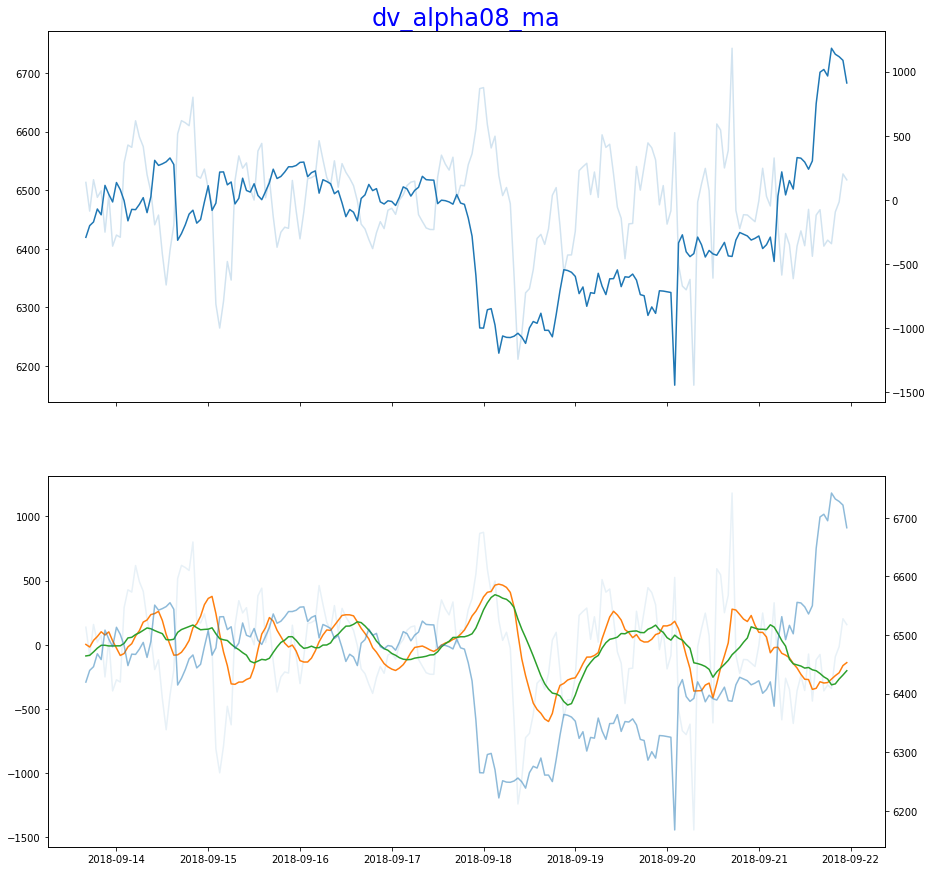

In [2]:
alpha = dv1H.get_ts('alpha08_C', date_type='datetime')
Plot_Mean(dv1H, alpha.iloc[:,0], chart_name='dv_alpha08_ma',ShortPeriod=10, LongPeriod=15, n=-200)
#橘色短线 绿色长线

In [3]:
#研究报告
##因子：alpha08 公式：-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))
## 线：橘色为alpha08的10日短线，绿色为alpha08的15日长线，蓝色为此时间段内股价的走势，浅蓝色为alpha08此区间内的走势
##现象：可以发现alpha08的走势与股价的走势几乎是呈现镜像的

#进出场条件：由于alpha08与股价走势存在着相反的关系，所以由观察所得的入场条件
##进场：当alpha08的10日短线下穿15日长线时买入
##出场：当alpha08的10日短线上穿15日长线时卖出

In [4]:
# 进场信号
long = dv1H.add_formula("longAlpha08","If((Ts_Mean(alpha08_C,10)<Ts_Mean(alpha08_C,15)) && (Delay(Ts_Mean(alpha08_C,10),1)>=Delay(Ts_Mean(alpha08_C,15),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha08","If((Ts_Mean(alpha08_C,10)>Ts_Mean(alpha08_C,15)) && (Delay(Ts_Mean(alpha08_C,10),1)<=Delay(Ts_Mean(alpha08_C,15),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha08","If(shortAlpha08==2,-1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha08","If(longAlpha08==-2,1,0)", add_data=True)

In [5]:
dv1H.get_ts('longAlpha08').stack()[dv1H.get_ts('longAlpha08').stack()==2].tail()

trade_date      symbol         
20180918090000  BTCUSDT:binance    2.0
20180919140000  BTCUSDT:binance    2.0
20180920040000  BTCUSDT:binance    2.0
20180921000000  BTCUSDT:binance    2.0
20180921100000  BTCUSDT:binance    2.0
dtype: float64

In [6]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [7]:
from jaqs_fxdayu.research import TimingDigger
tdAlpha08 = TimingDigger(output_folder="./output08", output_format='pdf',signal_name='Alpha008')
TimingSignal(tdAlpha08, dv1H,'longAlpha08','shortAlpha08','closeLongAlpha08','closeShortAlpha08', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [8]:
tdAlpha08.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               14.344  -26.881    0.933
p-value               0.000    0.000    0.352
mean                  0.053   -0.043    0.003
std                   0.045    0.020    0.059
info_ratio            1.191   -2.152    0.054
skewness              1.030    0.705    0.823
kurtosis              0.468   -0.615    0.084
pct5                  0.003   -0.069   -0.063
pct25                 0.018   -0.056   -0.052
pct50                 0.039   -0.052   -0.002
pct75                 0.083   -0.029    0.038
pct95                 0.143   -0.004    0.114
occurance           146.000  157.000  303.000
win_ratio               NaN      NaN    0.482
win_mean/loss_mean      NaN      NaN    1.227


In [9]:
tdAlpha08.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               9.150 -19.509    0.117
p-value              0.000   0.000    0.907
mean                 0.048  -0.045    0.001
std                  0.044   0.020    0.058
info_ratio           1.071  -2.253    0.010
skewness             1.722   0.912    0.989
kurtosis             2.373  -0.317    0.965
pct5                 0.007  -0.069   -0.065
pct25                0.018  -0.058   -0.053
pct50                0.033  -0.053   -0.002
pct75                0.054  -0.031    0.033
pct95                0.163  -0.003    0.110
occurance           74.000  76.000  150.000
win_ratio              NaN     NaN    0.493
win_mean/loss_mean     NaN     NaN    1.052


In [10]:
tdAlpha08.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              11.253 -18.562    1.173
p-value              0.000   0.000    0.242
mean                 0.059  -0.042    0.006
std                  0.044   0.020    0.060
info_ratio           1.336  -2.075    0.095
skewness             0.361   0.529    0.672
kurtosis            -0.783  -0.778   -0.616
pct5                 0.001  -0.064   -0.062
pct25                0.018  -0.055   -0.052
pct50                0.064  -0.051   -0.005
pct75                0.093  -0.028    0.046
pct95                0.125  -0.005    0.111
occurance           72.000  81.000  153.000
win_ratio              NaN     NaN    0.471
win_mean/loss_mean     NaN     NaN    1.419


In [11]:
# 因子一：alpha08/alpha101 通用性测试

import warnings
from jaqs_fxdayu.data.dataservice import LocalDataService
warnings.filterwarnings('ignore')
ds = LocalDataService()

## 加freq参数
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'EOSUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

data1H = Time_dict.set_index('datetime')

import matplotlib.pyplot as plt
import pandas as pd

def Plot_Mean(dv, alpha, chart_name='dv_alpha08_ma', ShortPeriod=20, LongPeriod=55, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax2 = ax.twinx()
    ax2.plot(alpha.iloc[n:], alpha=0.2)
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    ax3 = ax1.twinx()
    ax3.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:],alpha=0.5)
#     plt.savefig(chart_name)
    plt.show()

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

dv1H.add_formula('alpha08_C',"-1*((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5))-Delay((Ts_Sum(open,5)*Ts_Sum(Return(close,1),5)),10))",add_data=True).tail(10)

Initialize dataview success.


symbol,EOSUSDT:binance
trade_date,
20180921140000,-0.138277
20180921150000,0.659394
20180921160000,1.450949
20180921170000,1.897205
20180921180000,1.448410
20180921190000,1.188501
20180921200000,1.088227
20180921210000,-0.104951
20180921220000,-0.642860


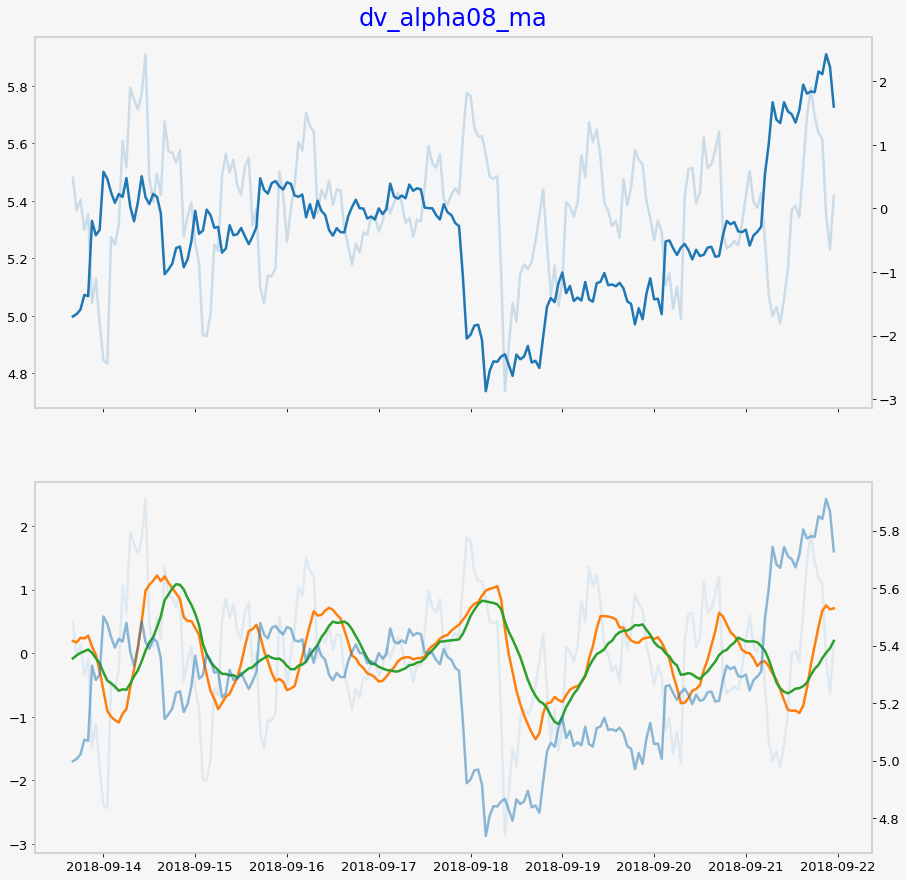

In [12]:
alpha = dv1H.get_ts('alpha08_C', date_type='datetime')
Plot_Mean(dv1H, alpha.iloc[:,0], chart_name='dv_alpha08_ma',ShortPeriod=10, LongPeriod=15, n=-200)
#橘色短线 绿色长线

In [13]:
long = dv1H.add_formula("longAlpha08","If((Ts_Mean(alpha08_C,10)<Ts_Mean(alpha08_C,15)) && (Delay(Ts_Mean(alpha08_C,10),1)>=Delay(Ts_Mean(alpha08_C,15),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha08","If((Ts_Mean(alpha08_C,10)>Ts_Mean(alpha08_C,15)) && (Delay(Ts_Mean(alpha08_C,10),1)<=Delay(Ts_Mean(alpha08_C,15),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha08","If(shortAlpha08==2,-1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha08","If(longAlpha08==-2,1,0)", add_data=True)

In [14]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [15]:
from jaqs_fxdayu.research import TimingDigger
tdAlpha08 = TimingDigger(output_folder="./output08", output_format='pdf',signal_name='Alpha008')
TimingSignal(tdAlpha08, dv1H,'longAlpha08','shortAlpha08','closeLongAlpha08','closeShortAlpha08', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [16]:
tdAlpha08.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               15.364  -44.225    1.972
p-value               0.000    0.000    0.050
mean                  0.117   -0.060    0.012
std                   0.085    0.018    0.103
info_ratio            1.374   -3.251    0.112
skewness              0.700    1.023    1.196
kurtosis             -0.554    2.532    0.446
pct5                  0.015   -0.086   -0.080
pct25                 0.048   -0.070   -0.063
pct50                 0.097   -0.060   -0.052
pct75                 0.185   -0.053    0.067
pct95                 0.294   -0.013    0.232
occurance           126.000  186.000  312.000
win_ratio               NaN      NaN    0.404
win_mean/loss_mean      NaN      NaN    1.954


In [17]:
tdAlpha08.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               9.628  -38.745   -0.823
p-value              0.000    0.000    0.412
mean                 0.124   -0.060   -0.006
std                  0.085    0.016    0.097
info_ratio           1.451   -3.728   -0.067
skewness             0.800    0.993    1.652
kurtosis            -0.182    3.550    1.940
pct5                 0.006   -0.083   -0.079
pct25                0.062   -0.070   -0.065
pct50                0.107   -0.059   -0.054
pct75                0.155   -0.053    0.053
pct95                0.301   -0.032    0.210
occurance           45.000  109.000  154.000
win_ratio              NaN      NaN    0.292
win_mean/loss_mean     NaN      NaN    2.057


In [18]:
tdAlpha08.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              11.940 -24.428    3.417
p-value              0.000   0.000    0.001
mean                 0.113  -0.060    0.029
std                  0.085   0.021    0.107
info_ratio           1.335  -2.802    0.273
skewness             0.648   0.971    0.865
kurtosis            -0.802   1.432   -0.302
pct5                 0.021  -0.093   -0.081
pct25                0.036  -0.070   -0.062
pct50                0.082  -0.062    0.013
pct75                0.185  -0.054    0.086
pct95                0.274  -0.010    0.232
occurance           81.000  77.000  158.000
win_ratio              NaN     NaN    0.513
win_mean/loss_mean     NaN     NaN    1.904
